# 판매준비하기 AB test 분석

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests


# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

Metric 1. 비교견적 신청 전환율



✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3970,37448,10.60%
1,B,4251,37696,11.28%
2,C,4259,37682,11.30%
3,D,4256,37460,11.36%




✅ Group Conversion Rates
A group conversion rate: 10.60%
B group conversion rate: 11.28%
C group conversion rate: 11.30%
D group conversion rate: 11.36%


✅ Chi-square Test
- Chi2 statistic: 14.5537
- p-value: 0.0022


✅ Pairwise comparison results after Holm-Bonferroni correction:


,Comparison,Uncorrected p-value,Corrected p-value,Significant
0,A vs B,0.0030,0.0120,True
1,A vs C,0.0021,0.0105,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,1.0000,False
4,B vs D,0.7150,1.0000,False
5,C vs D,0.7987,1.0000,False




✅ Pairwise comparison results after FDR correction (Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0030,0.0060,True
1,A vs C,0.0021,0.0060,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,0.9122,False
4,B vs D,0.7150,0.9122,False
5,C vs D,0.7987,0.9122,False


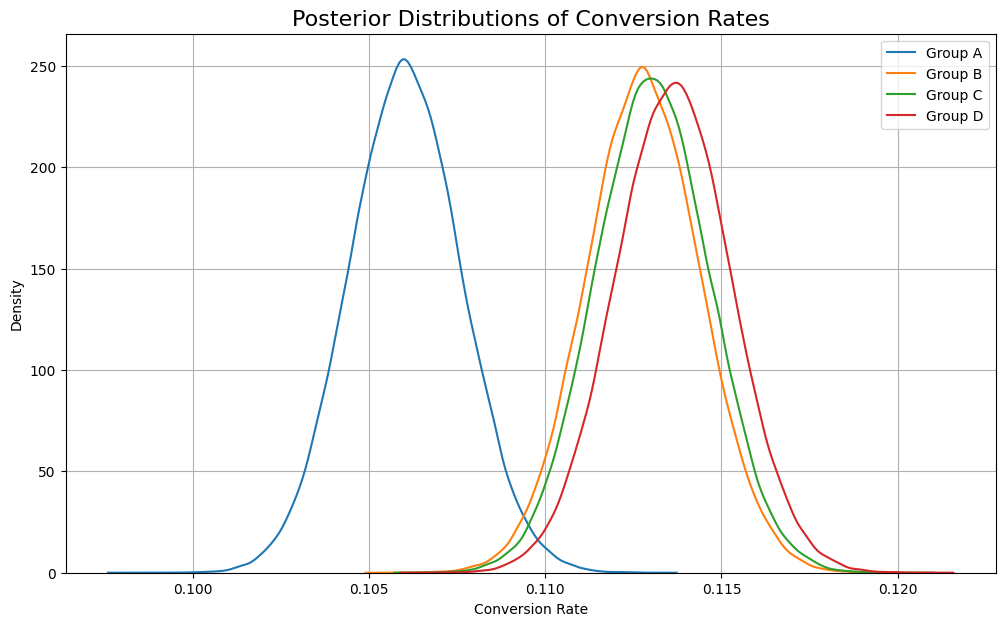



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 24.07%
Probability that C is the best: 29.77%
Probability that D is the best: 46.16%




✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0016,0.9984
1,A > C,0.0011,0.9989
2,A > D,0.0004,0.9996
3,B > C,0.4559,0.5441
4,B > D,0.3577,0.6423
5,C > D,0.4005,0.5995


In [13]:

# ✅ 데이터 준비
groups = ['A', 'B', 'C', 'D']
successes = np.array([3970, 4251, 4259, 4256])
trials = np.array([37448, 37696, 37682, 37460])
failures = trials - successes
conversion_rates = successes / trials


# ✅ 그룹별 상세 지표 출력 (성공 수, 전체 수, 전환율)
group_summary = pd.DataFrame({
    'Group': groups,
    'Successes': successes,
    'Trials': trials,
    # 'Conversion Rate': conversion_rates,
    'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
})

print("\n" + "="*60)
print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
display(group_summary)



# ✅ 그룹별 전환율 출력
print("\n" + "="*60)
print("\n✅ Group Conversion Rates")
for grp, rate in zip(groups, conversion_rates):
    print(f"{grp} group conversion rate: {rate:.2%}")

# ✅ 전통적 통계검정: Chi-square test
contingency_table = np.array([successes, failures]).T
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("\n" + "="*60)
print("\n✅ Chi-square Test")
print(f"- Chi2 statistic: {chi2:.4f}")
print(f"- p-value: {p_value:.4f}")

# 빈도주의 보수적 방식
# ✅ 사후 Pairwise Z-test (Holm-Bonferroni 보정)
pairwise_results = []
pairs = []

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        count = np.array([successes[i], successes[j]])
        nobs = np.array([trials[i], trials[j]])
        z_stat, p = proportions_ztest(count, nobs)
        pairwise_results.append(p)
        pairs.append(f"{groups[i]} vs {groups[j]}")

reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')

results_df = pd.DataFrame({
    'Comparison': pairs,
    'Uncorrected p-value': pairwise_results,
    'Corrected p-value': pvals_corrected,
    'Significant': reject
})

print("\n" + "="*60)
print("\n✅ Pairwise comparison results after Holm-Bonferroni correction:")
display(results_df)



# 빈도주의 유연한 방식
# ✅ 사후 Pairwise Z-test (FDR 보정, 유연한 방식)
pairwise_results_fdr = []
pairs_fdr = []

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        count = np.array([successes[i], successes[j]])
        nobs = np.array([trials[i], trials[j]])
        z_stat, p = proportions_ztest(count, nobs)
        pairwise_results_fdr.append(p)
        pairs_fdr.append(f"{groups[i]} vs {groups[j]}")

reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results_fdr, alpha=0.05, method='fdr_bh')

results_df_fdr = pd.DataFrame({
    'Comparison': pairs_fdr,
    'Uncorrected p-value': pairwise_results_fdr,
    'Corrected p-value (FDR)': pvals_fdr_corrected,
    'Significant (FDR)': reject_fdr
})

print("\n" + "="*60)
print("\n✅ Pairwise comparison results after FDR correction (Benjamini-Hochberg):")
display(results_df_fdr)

print("\n")


# ✅ Bayesian 분석 설정 (Beta prior 사용) 10만번
samples = 100_000

# np.random.seed(42)  # 원하는 정수 사용 -> 베이지안 결과값 고정하기 위함 -> 랜덤 샘플의 시드 고정하는 코드

posterior_samples = {
    group: np.random.beta(1 + success, 1 + fail, samples)
    for group, success, fail in zip(groups, successes, failures)
}

# ✅ Bayesian posterior 분포 시각화
plt.figure(figsize=(12, 7))
x = np.linspace(0.1, 0.3, 1000)

for group in groups:
    sns.kdeplot(posterior_samples[group], label=f'Group {group}')

plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Bayesian: 각 그룹이 가장 우수할 확률 계산
best_group_count = {group: 0 for group in groups}

# Monte-Carlo simulation to find best group probability
for i in range(samples):
    best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
    best_group_count[best_group] += 1


print("\n" + "="*60)
print("\n✅ Bayesian: Probability that each group is best")
for group, count in best_group_count.items():
    prob = count / samples
    print(f"Probability that {group} is the best: {prob:.2%}")

print("\n")

# ✅ Bayesian 결과 시각화 (위 text에 대한 단순 시각화이기 때문에 일단 스킵)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=list(best_group_count.keys()),
#             y=np.array(list(best_group_count.values()))/samples)
# plt.title('Probability of Being the Best Group', fontsize=16)
# plt.xlabel('Group')
# plt.ylabel('Probability')
# plt.ylim(0, 1)
# plt.grid(True, axis='y')
# plt.show()

# ✅ Bayesian: 쌍별 우위 확률 계산
pairwise_bayes = []
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        g1, g2 = groups[i], groups[j]
        prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
        pairwise_bayes.append({
            'Comparison': f"{g1} > {g2}",
            'P(Group1 > Group2)': prob,
            'P(Group1 < Group2)': 1 - prob
        })

# DataFrame으로 출력 (쌍별 우위확률 계산)
df_bayes = pd.DataFrame(pairwise_bayes)
print("\n" + "="*60)
print("\n✅ Bayesian Pairwise Superiority Probabilities:")
display(df_bayes)